In [1]:
#import libraries

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

from tensorflow.keras import layers, models
from keras.models import load_model


modelName="Model_FromScratch_planning80epochs_complexUnet_AllDataset"

2023-12-05 01:34:58.916388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 01:34:59.078322: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 01:35:00.023293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-0

In [2]:
print(os.getcwd())

/home/jupyter


In [3]:
#code to create the required directory if needed
#print(os.getcwd())
#creating the folders based on the list of folder name

#orig_data_dir is the main folder of original images
orig_data_dir="AerialImageDataset"
orig_images_dir_X_train=os.path.join(orig_data_dir,"train","images")
orig_images_dir_y_train=os.path.join(orig_data_dir,"train","gt")

print(orig_images_dir_X_train)
#folder names of destination after tiling the images
list_foldersnames = ['train', 'train_masks']

#Creating the desination directory folders
for folder in list_foldersnames:
    folder_path = os.path.join(os.getcwd(), folder)
    if not os.path.exists(folder_path):
         os.mkdir(folder_path)
         print(f"Folder created sucessfully: {folder_path}")
    else:
          print(f"Folder {folder_path} is available")
        #print(folder_path)


AerialImageDataset/train/images
Folder /home/jupyter/train is available
Folder /home/jupyter/train_masks is available


In [4]:
#tiling the images based on a specific tile_sie
def tile_image(input_path, output_folder, tile_size,file_name):
    
    #print(file_name)
    # Open the input image

    input_image = Image.open(os.path.join(input_path))

    # Get the dimensions of the input image
    input_width, input_height = input_image.size

    # Calculate the number of tiles in both dimensions
    num_tiles_x = input_width // tile_size
    num_tiles_y = input_height // tile_size

    # Extract tiles and save them
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            # Calculate the cropping box
            left = i * tile_size
            upper = j * tile_size
            right = left + tile_size
            lower = upper + tile_size

            # Crop the tile from the input image
            tile = input_image.crop((left, upper, right, lower))

            # Save the tile to the output folder
            tile.save(os.path.join(output_folder, f'{file_name}__tile_{i}_{j}.png'))


# Tiling Images

In [5]:
#Defining the parameters for tiling images

#Tile size of output image
tile_size = 250

## Tiling the Train Imges Dataset

In [6]:
"""

#setting the output folder to train folder in the main directory
output_folder = os.path.join(os.getcwd(),list_foldersnames[0])

#looping through 
for dirpath,dirnames,filenames in os.walk(orig_images_dir_X_train):
    for filename in filenames:
        input_path=os.path.join(dirpath,filename)
        filename=filename[:-4]
        tile_image(input_path, output_folder, tile_size,filename)
        
    # dirpath it will list all the directories(full path available under data_dir)
    # dirnames: it lists all the folders available under dirpath
    #filenames: it lists all the files available under dirpath

"""

'\n\n#setting the output folder to train folder in the main directory\noutput_folder = os.path.join(os.getcwd(),list_foldersnames[0])\n\n#looping through \nfor dirpath,dirnames,filenames in os.walk(orig_images_dir_X_train):\n    for filename in filenames:\n        input_path=os.path.join(dirpath,filename)\n        filename=filename[:-4]\n        tile_image(input_path, output_folder, tile_size,filename)\n        \n    # dirpath it will list all the directories(full path available under data_dir)\n    # dirnames: it lists all the folders available under dirpath\n    #filenames: it lists all the files available under dirpath\n\n'

## Tiling the Label Imges Dataset

In [7]:
"""
#setting the output folder to train folder in the main directory
output_folder = os.path.join(os.getcwd(),list_foldersnames[1])

#looping through 
for dirpath,dirnames,filenames in os.walk(orig_images_dir_y_train):
    for filename in filenames:
        input_path=os.path.join(dirpath,filename)
        filename=filename[:-4]
        tile_image(input_path, output_folder, tile_size,filename)
"""

'\n#setting the output folder to train folder in the main directory\noutput_folder = os.path.join(os.getcwd(),list_foldersnames[1])\n\n#looping through \nfor dirpath,dirnames,filenames in os.walk(orig_images_dir_y_train):\n    for filename in filenames:\n        input_path=os.path.join(dirpath,filename)\n        filename=filename[:-4]\n        tile_image(input_path, output_folder, tile_size,filename)\n'

In [8]:
for dirpath,dirnames,filenames in os.walk(orig_images_dir_y_train):
    print(f"dirpath: {dirpath} dirnames: {dirnames}")

dirpath: AerialImageDataset/train/gt dirnames: []


In [9]:
images=[]
labels=[]

In [10]:
for dirpath,dirnames,filenames in os.walk(os.path.join(os.getcwd(),list_foldersnames[0])):
    # Filter out hidden files from filenames list
    filenames = [filename for filename in filenames if not filename.startswith('.')]
    for filename in filenames:
        images.append(os.path.join(dirpath,filename))
print(len(images))        

72000


In [11]:
def prepare_dataframe(image_path,name):
    solar_ids = []
    paths = []
    for dirname, _, filenames in os.walk(image_path): #loop through all the images under all the directory image_path
        filenames = [filename for filename in filenames if not filename.startswith('.')]
        for filename in filenames:
            path = os.path.join(dirname, filename)    
            paths.append(path)

            solar_id = filename.split(".")[0]
            solar_ids.append(solar_id)

    d = {"id": solar_ids, name: paths}
    df = pd.DataFrame(data = d)
    #df = df.set_index('id')
    #df.reset_index()
    return df    

In [12]:
pd.set_option('display.max_colwidth', None)
image_root=os.getcwd() + '/train'
df=prepare_dataframe(image_root,"roof_path")
#print(df.shape)

label_root=os.getcwd() + '/train_masks'
mask_df=prepare_dataframe(label_root,"mask_path")

df=df.merge(mask_df,on='id')

print(df.shape)

df.head()
df.set_index('id',drop=True,inplace=True)

print(df.shape)
df.head()

(72000, 3)
(72000, 2)


,roof_path,mask_path
id,,
chicago24__tile_8_17,/home/jupyter/train/chicago24__tile_8_17.png,/home/jupyter/train_masks/chicago24__tile_8_17.png
austin23__tile_6_18,/home/jupyter/train/austin23__tile_6_18.png,/home/jupyter/train_masks/austin23__tile_6_18.png
chicago31__tile_18_8,/home/jupyter/train/chicago31__tile_18_8.png,/home/jupyter/train_masks/chicago31__tile_18_8.png
austin35__tile_9_8,/home/jupyter/train/austin35__tile_9_8.png,/home/jupyter/train_masks/austin35__tile_9_8.png
vienna25__tile_2_5,/home/jupyter/train/vienna25__tile_2_5.png,/home/jupyter/train_masks/vienna25__tile_2_5.png


In [13]:
print(df['roof_path'][0])

/home/jupyter/train/chicago24__tile_8_17.png


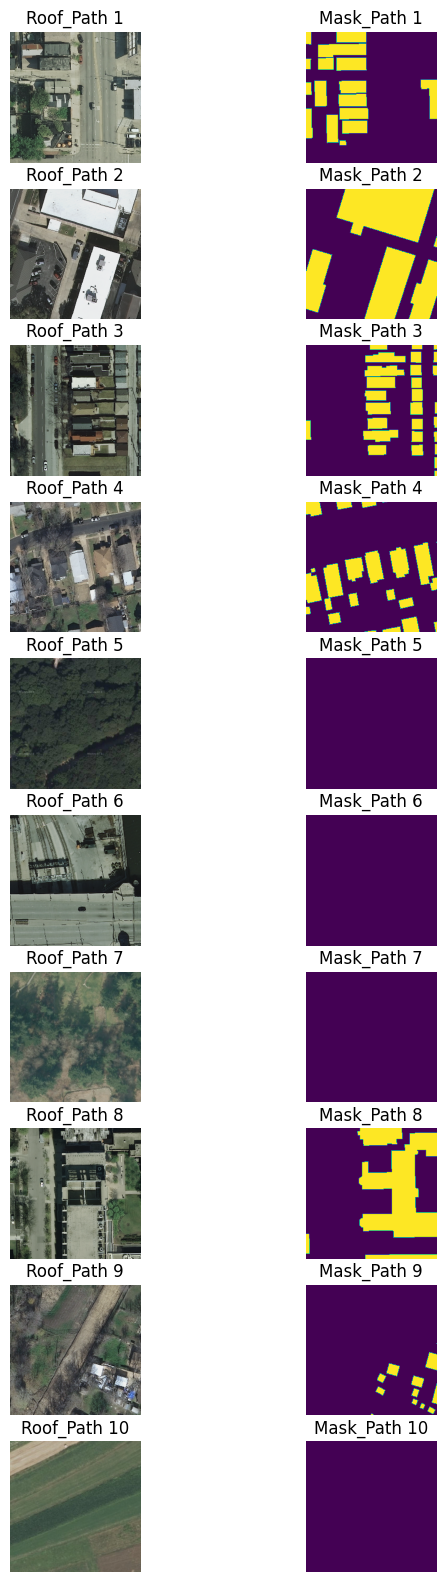

In [14]:
fig, axs = plt.subplots(10, 2, figsize=(7, 20))
 
for i in range(10):
    img=Image.open(df['roof_path'][i])
    # Convert the image to RGB format if it's not already in RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
 # Convert the image to a NumPy array
    img_array = np.array(img)
    axs[i,0].imshow(img_array)
    axs[i,0].axis('off')
    axs[i, 0].set_title(f'Roof_Path {i+1}')

    img_mask=Image.open(df['mask_path'][i])
    # Convert the image to RGB format if it's not already in RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
 # Convert the image to a NumPy array
    img_mask_array = np.array(img_mask)
    axs[i,1].imshow(img_mask_array)
    axs[i,1].axis('off')
    axs[i, 1].set_title(f'Mask_Path {i+1}')


In [15]:
import tensorflow as tf

In [16]:
img_size=(250,250)

def data_augmentation(solar_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        solar_img = tf.image.flip_left_right(solar_img)
        mask_img = tf.image.flip_left_right(mask_img)


def preprocessing(solar_path, mask_path):
    solar_img = tf.io.read_file(solar_path) 
    solar_img = tf.image.decode_image(solar_img, channels=3, dtype=tf.float32,expand_animations=False)
    solar_img = tf.image.resize(solar_img,img_size)
    solar_img = tf.cast(solar_img, tf.float32) / 255.0
    #solar_img=tf.reshape(solar_img, (250,250,3))
        
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_image(mask_img, channels=1, dtype=tf.float32,expand_animations=False)
    mask_img = tf.image.resize(mask_img,img_size)
    #solar_img=tf.reshape(solar_img, (250,250,3))
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    
    return solar_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        #ds = ds.batch(16)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        #ds = ds.batch(16)
        #ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

def display(display_list):
    plt.figure(figsize=(15, 15))
#    title = ['Input Image', 'True Mask', 'Predicted Mask']
    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [17]:
"""
ds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))

ds = ds.map(preprocessing)
ds = ds.batch(2)

for img_path, mask_path in ds:
    #solar_img = tf.io.read_file(img_path)
    #print(solar_img)
    #print(img_path)
    display(img_path)
    display(mask_path)
    #print(mask_path)
    break
    """

'\nds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))\n\nds = ds.map(preprocessing)\nds = ds.batch(2)\n\nfor img_path, mask_path in ds:\n    #solar_img = tf.io.read_file(img_path)\n    #print(solar_img)\n    #print(img_path)\n    display(img_path)\n    display(mask_path)\n    #print(mask_path)\n    break\n    '

In [18]:
# Now we will split the dataset into train and test
train_df, valid_df = train_test_split(df,random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)


2023-12-05 01:35:03.766179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 01:35:04.463786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20613 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [19]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 30
BUFFER_SIZE = 1000

In [20]:
#train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_dataset = train.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [21]:
"""
print(type(train))
print(list(train.as_numpy_iterator()))
"""

'\nprint(type(train))\nprint(list(train.as_numpy_iterator()))\n'

<ParallelMapDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 250, 1), dtype=tf.float32, name=None))>


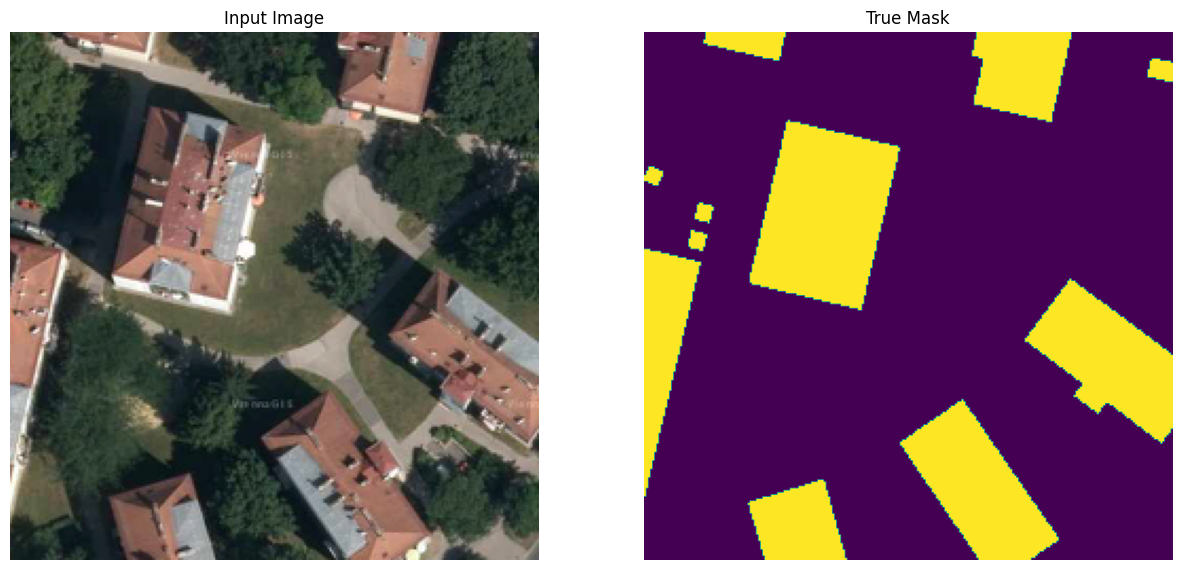

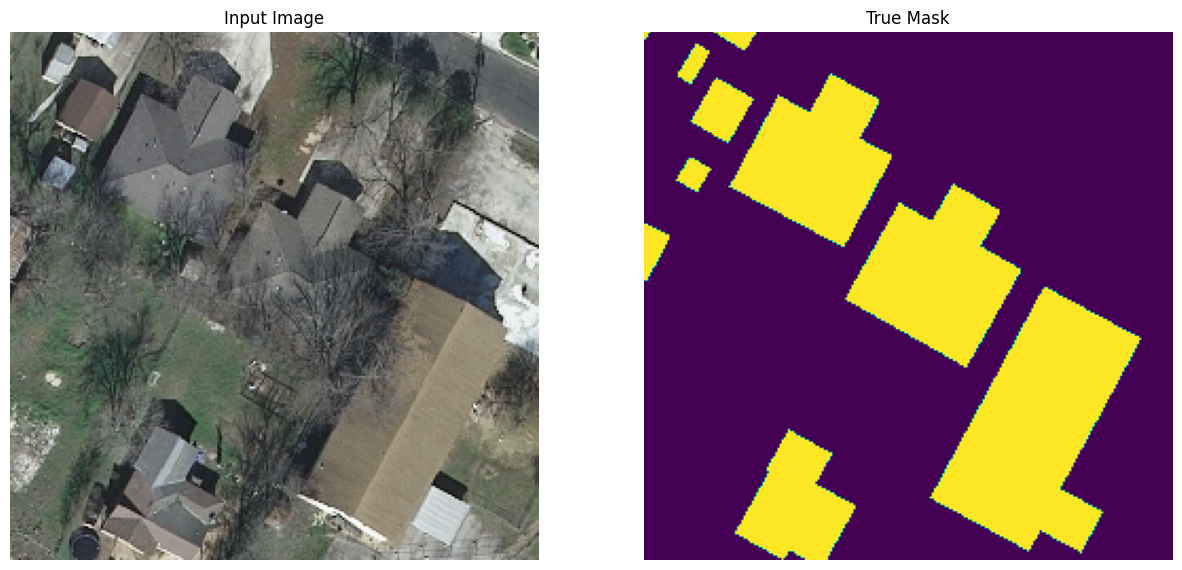

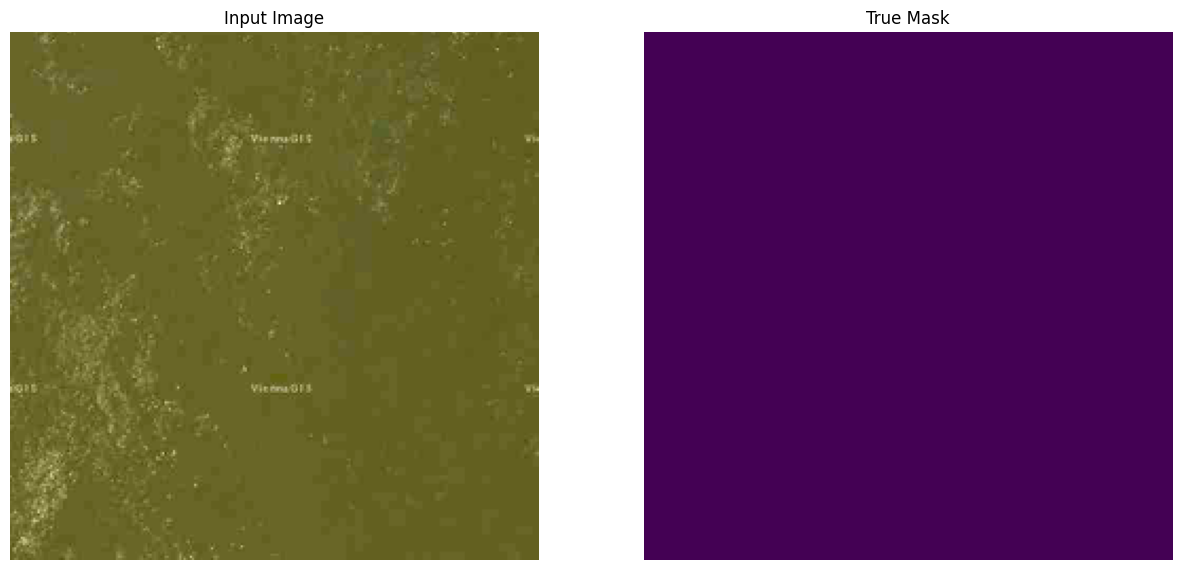

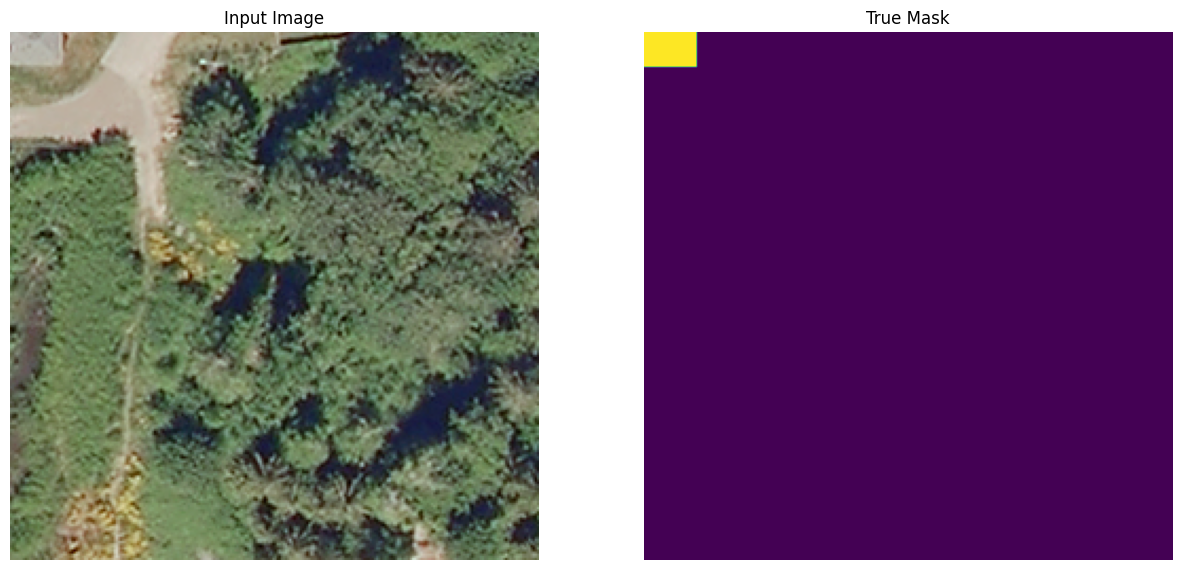

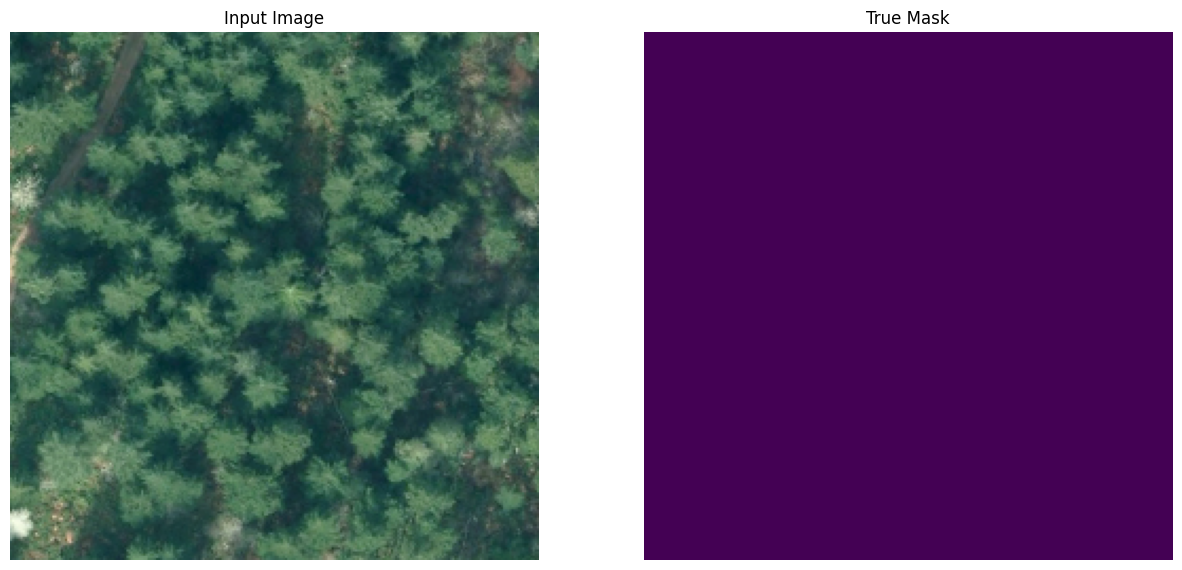

In [22]:

# Let's look the image and it's corresponding mask
print(train)
#for i in range(5):
for image, mask in train.take(5):
    #print(image)
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# Model

# Training the model

In [23]:
#model=unet_model(1)

In [24]:
"""
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import tensorflow as tf
from tensorflow.keras import layers, models
 
# Adjusted input shape
input_shape = (250, 250, 3)
 
# Define the U-Net model with reduced parameters
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
 
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
 
    # Bottleneck
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
 
    # Decoder
    up3 = layers.UpSampling2D(size=(2, 2))(conv2)
    concat3 = layers.Concatenate()([conv1, up3])
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv3)
 
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv3)
 
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
 
# Create the U-Net model
model = unet_model(input_shape)
 
# Display the model summary
model.summary()

"""

"\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\n \n# Adjusted input shape\ninput_shape = (250, 250, 3)\n \n# Define the U-Net model with reduced parameters\ndef unet_model(input_shape):\n    inputs = tf.keras.Input(shape=input_shape)\n \n    # Encoder\n    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)\n    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)\n    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)\n \n    # Bottleneck\n    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)\n    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)\n \n    # Decoder\n    up3 = layers.Up

In [25]:

def unet_model(input_shape=(250, 250, 3)):
    inputs = tf.keras.Input(shape=input_shape)
 
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
 
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
 
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
 
    # Bottleneck
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
 
    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate()([conv3, up5])
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)
 
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    pad6 = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(up6)  # Pad to match dimensions
    concat6 = layers.Concatenate()([conv2, pad6])
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)
 
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    concat7 = layers.Concatenate()([conv1, up7])
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)
 
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)
 
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
 
# Create the U-Net model
model = unet_model()
 
# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 250, 250, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [26]:
#model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

#losses=[dice_loss]

#losses=['binary_crossentropy',dice_loss]
losses=['binary_crossentropy']
#metrics=['accuracy',dice_coef,jaccard_metric,tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])]

#metrics=['accuracy',dice_coef,tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)]
#metrics=['accuracy',tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)]

metrics=['accuracy',tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])]
#metrics=['accuracy',dice_coef,"IoU"]
#model.compile(optimizer='adam',loss = dice_loss,metrics=[dice_coef,'binary_accuracy'])
#model.compile(optimizer="adam",loss=losses,metrics=metrics)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=adam, loss = losses, metrics=metrics)

In [27]:

#t=tf.expand_dims(train,axis=0)
type(train)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [28]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 30
BUFFER_SIZE = 1000

In [29]:
len(train_df)

54000

In [30]:
for img, mask in valid_dataset:
    print(img.shape)
    print(mask.shape)
    break

(30, 250, 250, 3)
(30, 250, 250, 1)


In [31]:
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(STEPS_PER_EPOCH)

1800


In [32]:
#train=tf.expand_dims(train,axis=-1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

checkpoint_filepath =os.path.join(os.getcwd(),"CheckPoints")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

EPOCHS = 80
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

nbr_of_images=72000
neg=nbr_of_images*250*250*0.84
print(neg)
pos=nbr_of_images*250*250*0.16
print(pos)
tot=nbr_of_images*250*250

weight_for_0=(1/neg)*(tot/2)
weight_for_1=(1/pos)*(tot/2)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


print(STEPS_PER_EPOCH)



model= load_model('ModelsGenerated/Model_FromScratch_Run10epochs_complexUnet_AllDataset_2023-12-04_17-49-50_2.h5')


model.summary()
history=model.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_dataset,verbose=1,callbacks=[model_checkpoint_callback,early_stop])

3780000000.0
720000000.0
Weight for class 0: 0.60
Weight for class 1: 3.12
1800
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 250, 250, 32  9248        ['conv2d[0][0]']                 
              

2023-12-05 01:35:12.413078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2023-12-05 01:35:15.128535: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc269781f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 01:35:15.128580: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2023-12-05 01:35:15.135326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 01:35:15.265995: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1800/1800 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.8429 - io_u: 0.4214

INFO:tensorflow:Assets written to: /home/jupyter/CheckPoints/assets


INFO:tensorflow:Assets written to: /home/jupyter/CheckPoints/assets


1800/1800 [==============================] - 569s 309ms/step - loss: 0.4351 - accuracy: 0.8429 - io_u: 0.4214 - val_loss: 0.4396 - val_accuracy: 0.8401 - val_io_u: 0.4200
Epoch 2/80
1800/1800 [==============================] - 552s 307ms/step - loss: 0.4350 - accuracy: 0.8429 - io_u: 0.4214 - val_loss: 0.4396 - val_accuracy: 0.8401 - val_io_u: 0.4200
Epoch 3/80
1800/1800 [==============================] - 553s 307ms/step - loss: 0.4350 - accuracy: 0.8429 - io_u: 0.4214 - val_loss: 0.4395 - val_accuracy: 0.8401 - val_io_u: 0.4200
Epoch 4/80
1800/1800 [==============================] - 553s 307ms/step - loss: 0.4350 - accuracy: 0.8429 - io_u: 0.4214 - val_loss: 0.4395 - val_accuracy: 0.8401 - val_io_u: 0.4200
Epoch 5/80
1800/1800 [==============================] - 552s 307ms/step - loss: 0.4350 - accuracy: 0.8429 - io_u: 0.4214 - val_loss: 0.4395 - val_accuracy: 0.8401 - val_io_u: 0.4200
Epoch 6/80
1800/1800 [==============================] - 552s 307ms/step - loss: 0.4350 - accuracy: 0.

In [33]:
!pip freeze | grep tensorflow

tensorflow==2.11.0
tensorflow-cloud==0.1.16
tensorflow-datasets==4.9.0
tensorflow-estimator==2.11.0
tensorflow-hub==0.15.0
tensorflow-io==0.29.0
tensorflow-io-gcs-filesystem==0.29.0
tensorflow-metadata==0.14.0
tensorflow-probability==0.22.1
tensorflow-serving-api==2.11.0
tensorflow-transform==0.14.0


In [34]:
#Save the model 
model.save('model_40epoch_binarycrossentropy_dec4.h5')

In [35]:
from datetime import datetime
current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create a filename with the formatted date and time
filename = f"data_{formatted_datetime}.txt"  # You can replace 'data' with your desired filename prefix

model.save(f"ModelsGenerated/{modelName}_{formatted_datetime}.h5")
print("Saved model to disk")

Saved model to disk


In [36]:
from datetime import datetime
current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")


import pickle
with open(f"HistoryGenerated/history_{modelName}_{formatted_datetime}.pkl", "wb") as file:
    pickle.dump(history.history,file)
    
print("History is saved")
    

History is saved


In [37]:
history.history


{'loss': [0.4351242482662201,
  0.43498799204826355,
  0.4349673390388489,
  0.4349628984928131,
  0.4349628686904907,
  0.4349628686904907,
  0.4349628686904907,
  0.4349628686904907],
 'accuracy': [0.8428812623023987,
  0.8428812623023987,
  0.8428812623023987,
  0.8428812623023987,
  0.8428812623023987,
  0.8428812623023987,
  0.8428812623023987,
  0.8428812623023987],
 'io_u': [0.4214329421520233,
  0.4214329421520233,
  0.4214329421520233,
  0.4214329421520233,
  0.4214329421520233,
  0.4214329421520233,
  0.4214329421520233,
  0.4214329421520233],
 'val_loss': [0.43956243991851807,
  0.439557820558548,
  0.43954944610595703,
  0.4395495355129242,
  0.4395495355129242,
  0.4395495355129242,
  0.4395494759082794,
  0.4395494759082794],
 'val_accuracy': [0.8400977849960327,
  0.8400977849960327,
  0.8400977849960327,
  0.8400977849960327,
  0.8400977849960327,
  0.8400977849960327,
  0.8400977849960327,
  0.8400977849960327],
 'val_io_u': [0.4200497567653656,
  0.4200497567653656,
 

In [38]:
#print(train)

In [39]:
print(f"Avg of loss: {round(np.mean(history.history['loss']),3)}")
print(f"Avg of accuracy: {round(np.mean(history.history['accuracy']),3)}")
print(f"Avg of IOU: {round(np.mean(history.history['io_u']),3)}")
print(f"Avg of val_loss: {round(np.mean(history.history['val_loss']),3)}")
print(f"Avg of val_accuracy: {round(np.mean(history.history['val_accuracy']),3)}")
print(f"Avg of val_IOU: {round(np.mean(history.history['val_io_u']),3)}")


Avg of loss: 0.435
Avg of accuracy: 0.843
Avg of IOU: 0.421
Avg of val_loss: 0.44
Avg of val_accuracy: 0.84
Avg of val_IOU: 0.42


We are going to use U-Net model. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder.The encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications.

In [40]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)

    epochs = range(1, len(history.history["loss"]) + 1)
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.plot(epochs, loss, "bo", label="Training loss", color="red")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Nbr of epochs")
    plt.legend()
    #plt.ylim(0.2,0.5)
    plt.subplot(1,2,2)

    epochs = range(1, len(history.history["accuracy"]) + 1)
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    plt.plot(epochs, accuracy, "bo", label="Training binary accuracy",color="red")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.xlabel("Nbr of epochs")
    plt.title("Training and validation accuracy")
    plt.legend()

/var/tmp/ipykernel_236635/2757509277.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label="Training loss", color="red")
/var/tmp/ipykernel_236635/2757509277.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label="Training binary accuracy",color="red")


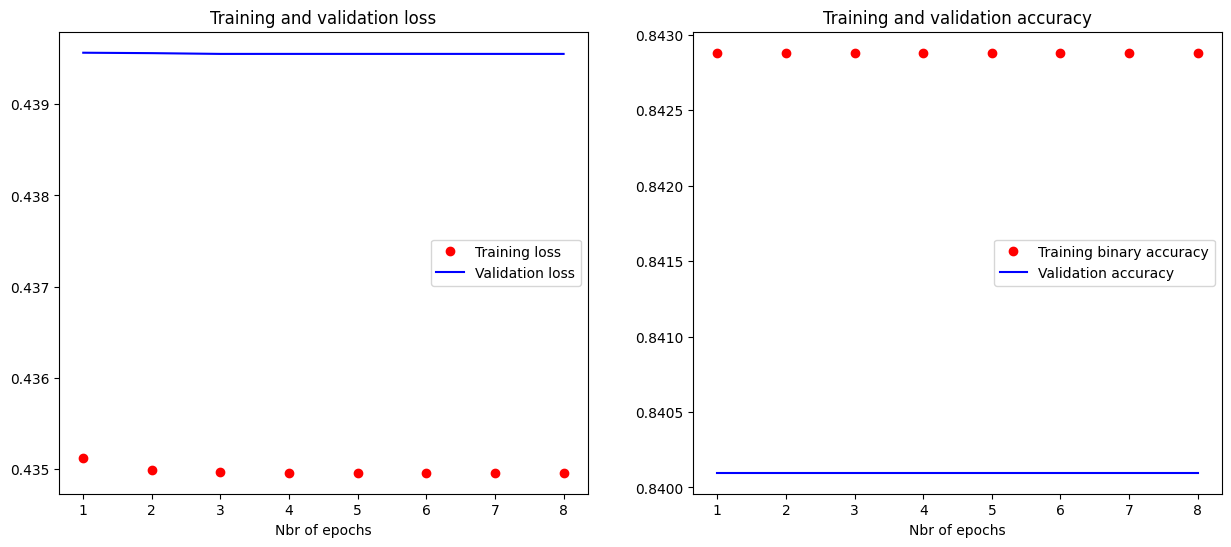

In [41]:
plot_history(history)

In [42]:
!ls -ltr

total 41007600
drwxrwxrwx 4 jupyter jupyter        4096 Oct 27  2016 AerialImageDataset
-rw-r--r-- 1 jupyter jupyter 20957265725 Nov 21  2016 NEW2-AerialImageDataset.zip
-rw-r--r-- 1 jupyter jupyter  4294967296 Jul  9  2018 aerialimagelabeling.7z.002
-rw-r--r-- 1 jupyter jupyter  4294967296 Jul  9  2018 aerialimagelabeling.7z.003
-rw-r--r-- 1 jupyter jupyter  4294967296 Jul  9  2018 aerialimagelabeling.7z.004
-rw-r--r-- 1 jupyter jupyter  4294967296 Jul  9  2018 aerialimagelabeling.7z.001
-rw-r--r-- 1 jupyter jupyter  3777396691 Jul  9  2018 aerialimagelabeling.7z.005
drwxr-xr-x 2 jupyter jupyter     3407872 Nov 28 10:14 train
drwxr-xr-x 2 jupyter jupyter     3407872 Nov 28 11:08 train_masks
drwxr-xr-x 2 jupyter jupyter        4096 Dec  1 04:09 assets
drwxr-xr-x 2 jupyter jupyter        4096 Dec  1 06:54 variables
-rw-r--r-- 1 jupyter jupyter          56 Dec  1 06:54 fingerprint.pb
-rw-r--r-- 1 jupyter jupyter     3008340 Dec  1 06:54 saved_model.pb
-rw-r--r-- 1 jupyter jupyter      39

In [43]:
#base_model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

# Let's observe how the model improves while it is training. 
# To accomplish this task, a callback function is defined below.
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])